In [1]:
%matplotlib inline

## Motivations
https://pytorch.org/tutorials/beginner/colab

https://github.com/Spandan-Madan/Pytorch_fine_tuning_Tutorial/blob/master/main_fine_tuning.py#L252

For testing robustness have a look at the following:

https://github.com/szegedai/robust-stitching

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
#import torchaudio
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load and transform data

In [3]:
transform = {
    'train': transforms.Compose([transforms.Resize(255),
                                 transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5],
                                                      [0.5, 0.5, 0.5])]),
    'val': transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
}
data_dir = 'data/hymenoptera_data/'
#dataset = datasets.ImageFolder(data_dir, transform=transform['train'])
dataset = {}
dataloader = {}
for x in ['train', 'val']:
    dataset[x] = datasets.ImageFolder(os.path.join(data_dir, x), transform=transform[x])
    dataloader[x] = torch.utils.data.DataLoader(dataset[x], batch_size=32, shuffle=True)

In [4]:
dataset

{'train': Dataset ImageFolder
     Number of datapoints: 246
     Root location: data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
                RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
            )}

In [87]:
# Need to investigate these sequential transforms

# transform = torch.nn.Sequential(
#     transforms.CenterCrop(10),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     transforms.ToTensor()
# )
# scripted_transform = torch.jit.script(transform)
# dataset2 = datasets.ImageFolder('data', transform=transform)

In [128]:
#dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True)

In [5]:
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x11716ac90>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x118051ed0>}

In [33]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


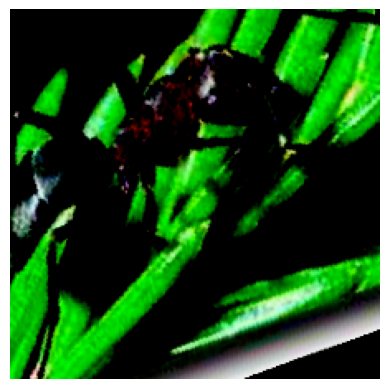

In [7]:
images, labels = next(iter(dataloader['train']))
imshow(images[0], normalize=False);

In [8]:
# Data augmentation example
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
dataset_aug = datasets.ImageFolder(data_dir, transform=train_transforms)

In [9]:
dataset_aug

Dataset ImageFolder
    Number of datapoints: 399
    Root location: data/hymenoptera_data/
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [10]:
dataloader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


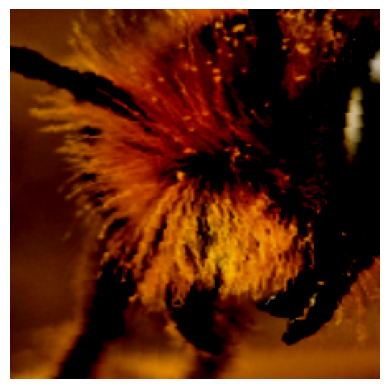

In [11]:
images, labels = next(iter(dataloader_aug))
imshow(images[0], normalize=False);

In [49]:
#def train_model(model, loss_function, optimizer, dataloader):
def train_model(dataloader, loss_function, model, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        print('Epoch number: {}'.format(epoch))
        for learning_mode in ['train', 'val']:
            if learning_mode == 'train':
                model.train()
            else:
                model.eval()
                
            for i, data in enumerate(dataloader[learning_mode]):
                images, labels = data
                #print(labels[0], np.shape(images))
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_function(outputs, labels)
                if learning_mode == 'train':
                    loss.backward()
                    optimizer.step()
                # outputs = model(images)
                _, preds = torch.max(outputs, 1)
                print(learning_mode+' loss:', loss.item())
                #print(loss_function(outputs, labels), labels[0], preds)
        
                #imshow(images[0], normalize=False)
        scheduler.step()

In [50]:
# Select loss function
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.SoftMarginLoss()

# Load a pre-trained model
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)
# Select Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# var1 = 0.1
# var2 = 0.01
# optimizer = optim.Adam([var1, var2], lr=0.0001)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_model(dataloader=dataloader, loss_function=loss_function, model=model, optimizer=optimizer, scheduler=scheduler)

Epoch number: 0
train loss: 0.8197059035301208
train loss: 0.6896455883979797
train loss: 0.7037371397018433
train loss: 0.7158427834510803
train loss: 0.6163105964660645
train loss: 0.5828511714935303
train loss: 0.7605273723602295
train loss: 0.6259185075759888
val loss: 0.640308141708374
val loss: 0.6559651494026184
val loss: 0.61467444896698
val loss: 0.6952794194221497
val loss: 0.5435370802879333
Epoch number: 1
train loss: 0.5850504636764526
train loss: 0.5636325478553772
train loss: 0.5515187382698059
train loss: 0.49062809348106384
train loss: 0.47424080967903137
train loss: 0.5090309977531433
train loss: 0.41241148114204407
train loss: 0.629151463508606
val loss: 0.5347678661346436
val loss: 0.5224288105964661
val loss: 0.4516039788722992
val loss: 0.33642011880874634
val loss: 0.3913460671901703
Epoch number: 2
train loss: 0.4750421941280365
train loss: 0.4265565276145935
train loss: 0.472252756357193
train loss: 0.3477485775947571
train loss: 0.4141346216201782
train loss: 

In [40]:
np.random.rand(2)

array([0.14393817, 0.20899394])

## Using Adam

In [41]:
# Select loss function
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.SoftMarginLoss()

# Load a pre-trained model
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)
# Select Optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# var1 = 0.1
# var2 = 0.01
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(dataloader=dataloader, loss_function=loss_function, model=model, optimizer=optimizer)

tensor(0) torch.Size([32, 3, 224, 224])
tensor(0.8403, grad_fn=<NllLossBackward0>) tensor(0) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor(0) torch.Size([32, 3, 224, 224])
tensor(0.9781, grad_fn=<NllLossBackward0>) tensor(0) tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])
tensor(1) torch.Size([32, 3, 224, 224])
tensor(0.8082, grad_fn=<NllLossBackward0>) tensor(1) tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1])
tensor(1) torch.Size([32, 3, 224, 224])
tensor(0.4807, grad_fn=<NllLossBackward0>) tensor(1) tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0])
tensor(1) torch.Size([32, 3, 224, 224])
tensor(0.6072, grad_fn=<NllLossBackward0>) tensor(1) tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
   